# DP2: Code

By Ashish Dhanalakota and Michal Marciniak

This is the code we used to control and simulate our differential drive robot, or segbot, and to plot its motion.

The first step is to import all the packages we need. Numpy, sympy, and scipy help with creating our initial matrices and finding the K matrices and eigenvalues that we seek to use. Time helps with the simulation of our segbot. Matplotlib helps with plotting the motion of the segbot. ae353_segbot, ipywidgets, and IPython.display are all needed to run and display the PyBullet simulator we use.

In [1]:
import time

# These modules are part of other existing libraries
import numpy as np
from sympy import *
from scipy import signal
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import asyncio

# This is to find our gain matrix
from scipy import linalg

# This is my own script (it is an interface to the pybullet simulator)
import ae353_segbot

Here, we define all our given constants.

In [4]:
# Dimensions of chassis
dx = 0.4
dy = 0.6
dz = 0.8

# Distance between axle and COM of chassis
h = 0.3

# Half-distance between wheels
a = 0.7 / 2

# Mass of chassis
mb = 12.

# MOI of chassis
Jbx = (mb / 12) * (dy**2 + dz**2)
Jby = (mb / 12) * (dx**2 + dz**2)
Jbz = (mb / 12) * (dx**2 + dy**2)

# Radius of each wheel
r = 0.325

# Width of each wheel
hw = 0.075

# Mass of each wheel
mw = 1.2

# MOI of each wheel
Jw = (mw / 2) * r**2
Jwt = (mw / 12) * (3 * r**2 + hw**2)

# Total mass
m = mb + 2 * mw

# Total MOI
Jx = Jbx + 2 * Jwt
Jy = Jby
Jz = Jbz + 2 * Jwt

# Station parameters
station_velocity = -0.5 # <-- FIXME (change the velocity to change gravity)
station_radius = 20.    # <-- radius in meters of inside surface of station

# Acceleration of artifical gravity
g = station_velocity**2 * station_radius

This converts all of our constants into rational numbers.

In [5]:
# Dimensions
h = nsimplify(h)
a = nsimplify(a)
r = nsimplify(r)

# Masses
mb = nsimplify(mb)
mw = nsimplify(mw)
m = nsimplify(m)

# MOIs
Jx = nsimplify(Jx)
Jy = nsimplify(Jy)
Jz = nsimplify(Jz)
Jw = nsimplify(Jw)
Jwt = nsimplify(Jwt)

# Gravity
g = nsimplify(g)

# Calculations

Define all variable through sympy, and flag them as real to help simplify.

In [6]:
(e_l, e_h, v, w, theta, thetadot, tau_R, 
 tau_L) = symbols('e_l, e_h, v, w, theta, thetadot, tau_R, tau_L', real=True)

Compute all the equations of motion except lateral and heading errors.

In [7]:
M = Matrix([[m + 2 * Jw / r**2, 0, mb * h * cos(theta)],
            [0, (Jx + mb * h**2) * sin(theta)**2 + Jz * cos(theta)**2 + (2 * Jw * a**2 / r**2) + 2 * mw * a**2, 0],
            [mb * h * cos(theta), 0, Jy * mb * h**2]])
N = Matrix([[mb * h * (w**2 + thetadot**2) * sin(theta)],
            [-2 * (Jx - Jz + m * h**2) * cos(theta) * sin(theta) * w * thetadot - mb * h * sin(theta) * v * w],
            [(Jx - Jz + mb * h**2) * cos(theta) * sin(theta) * w**2 + mb * g * h * sin(theta)]])
R = Matrix([[1 / r, 1 / r],
            [-a / r, a / r],
            [-1, -1]])

f_prep = simplify(M.inv() * (N + R * Matrix([[tau_L], [tau_R]])))

Compute full equations of motion, and decide our equilibrium points.

In [8]:
q = thetadot

# Defining our f matrix to take the Jacobian of
f = Matrix([[v * sin(e_h)], [w], [f_prep]])
f_new = Matrix([f[0], f[1], f[2], f[3], q, f[4]])

# Equilibrium points
le = 0 # lateral equilibrium, ldot = v*sin(h)
he = 0 # heading equilibrium, hdot = w
ve = 2 # forward speed, vdot = complex eqn1
we = 0 # turning rate, wdot = complex eqn2
thetae = 0 # pitch angle, thetadot = q
qe = 0 # NEEDS IMPLEMENTATION, qdot = complex eqn3
tau_Re = 0 # torque applied to right wheel
tau_Le = 0 # torque applied to left wheel

f_new

Matrix([
[                                                                                                                                                                           v*sin(e_h)],
[                                                                                                                                                                                    w],
[        -(1200*tau_L + 1200*tau_R + 1404*(thetadot**2 + w**2)*sin(theta) + 65*(50*tau_L + 50*tau_R - 39*w**2*sin(2*theta) - 900*sin(theta))*cos(theta)/2)/(5850*cos(theta)**2 - 6084)],
[                                                                    32*(-875*tau_L + 875*tau_R - 1443*thetadot*w*sin(2*theta) - 2925*v*w*sin(theta))/(13*(3120*sin(theta)**2 + 2051))],
[                                                                                                                                                                             thetadot],
[5*(4225*tau_L + 4225*tau_R - 6591*w**2*sin(2*theta)/2 + 30*(100*t

Here, we are creating A and B matrices for a state space model.

In [9]:
A_jac = f_new.jacobian([e_l, e_h, v, w, theta, q])
B_jac = f_new.jacobian([tau_R, tau_L])

# Defining A and B matrices for our state space model
A_num = lambdify([e_l, e_h, v, w, theta, q, tau_R, tau_L], A_jac)
A = A_num(le, he, ve, we, thetae, qe, tau_Re, tau_Le).astype(float)

B_num = lambdify([e_l, e_h, v, w, theta, q, tau_R, tau_L], B_jac)
B = B_num(le, he, ve, we, thetae, qe, tau_Re, tau_Le).astype(float)

print(A)

[[   0.            2.            0.            0.            0.
     0.        ]
 [   0.            0.            0.            1.            0.
     0.        ]
 [   0.            0.            0.            0.         -125.
    -0.        ]
 [   0.            0.            0.            0.            0.
     0.        ]
 [   0.            0.            0.            0.            0.
     1.        ]
 [   0.            0.            0.           -0.          541.66666667
    -0.        ]]


We are using LQR method to find optimal eigenvalues and a gain matrix with the given weights. Here, you can tell that pitch angle is weighted 100 times more than the other variables. This is because after extensive testing and simulations, we have determined that pitch angle is the most important factor in determining the stability of our segbot.

In [10]:
Q = np.diag([1, 1, 1, 1, 100, 1])

R = np.diag([1, 1])

#Using LQR method to find eigenvalues and a gain matrix

P = linalg.solve_continuous_are(A, B, Q, R)

K = linalg.inv(R) @  B.T @ P

linalg.eigvals(A - B @ K)

array([ -1.62405734+0.j        ,  -0.89803493+1.01116003j,
        -0.89803493-1.01116003j, -80.89852943+0.j        ,
       -11.24802614+0.j        ,  -0.16604362+0.j        ])

This is to just see the gain matrix.

In [11]:
K

array([[  0.70710678,   2.25960916,  -0.70710678,   1.62840806,
        -14.25293956,  -1.06282221],
       [ -0.70710678,  -2.25960916,  -0.70710678,  -1.62840806,
        -14.25293956,  -1.06282221]])

The purpose of this code is to test the controllability of our gain matrix using NumPy's mmatrix_rank function. If this outputs a rank that is equivalent to the number of states, that means that our system is fully controllable.

In [12]:
# Find the number of states
n = A.shape[0]

# Initialize W with its first column
W = B

# Create W one column at a time by iterating over i from 1 to n-1
for i in range(1, n):
    col = np.linalg.matrix_power(A, i) @ B
    W = np.block([W, col])

rank = np.linalg.matrix_rank(W)

rank

6

# Simulation

Simulate the segbot using the PyBullet simulator.

In [13]:
simulator = ae353_segbot.Simulator(
    display=True,
    bumpy=False,
)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


Set the controls and limits of the slider. Notice the `min` and `max` values: as stated in the report, these were adjusted to prevent the user from being able to easily drive the segbot off of the course.

In [14]:
slider = widgets.FloatSlider(
    value=0.,
    min=-2.4,
    max=2.4,
    step=0.01,
    description='Centerline:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
    layout=widgets.Layout(width='75%', border='solid 2px', margin='10px')
)

Set the simulation camera view to a back view, allowing the viewer to clearly see the segbot as it travels across the space station.

In [15]:
simulator.camera_backview()

Define a controller that maps sensor measurements to torque commands. This is where we use the gain matrix and equilibrium points from above.

In [16]:
class Controller:
    def __init__(self):
        self.lateral_error_tracker = np.array([])
        pass
    
    def reset(self):
        pass
    
    def run(
            self,
            t,
            lateral_error,
            heading_error,
            forward_speed,
            turning_rate,
            pitch_angle,
            pitch_rate,
        ):
        
        max_lateral = 1.7
        
        if lateral_error < -1 * max_lateral:
            lateral_error_new = -1 * max_lateral        
        elif lateral_error > max_lateral:
            lateral_error_new = max_lateral
        else:
            lateral_error_new = lateral_error
        
        x = np.array([[lateral_error_new],
                      [heading_error],
                      [forward_speed - 2], 
                      [turning_rate],
                      [pitch_angle],
                      [pitch_rate]])
        
        u = -K @ x
        
        # FIXME: replace the following lines
        right_wheel_torque = u[0][0]
        left_wheel_torque = u[1][0]
        
        return right_wheel_torque, left_wheel_torque

Create an instance of the controller.

In [17]:
controller = Controller()

# Trial 1: Testing the Slider Edges

Reset the simulator with given initial conditions. Notice how the station velocity is kept constant.

In [18]:
simulator.reset(
    initial_speed=1.,
    initial_lateral_error=0.,
    initial_heading_error=0.,
    initial_pitch=0.,
    station_velocity=-0.5,
)

Reset the segbot, and reset the slider value to 0.

In [19]:
controller.reset()
slider.value = 0.

Run the simulation for 15 seconds asynchronously to allow use of the slider.

In [20]:
# Show the slider, to allow steering the robot
display(slider)

# Run the simulation asynchronously, to allow using the slider
obj = asyncio.ensure_future(
    simulator.run(
        controller,           # <-- required (an instance of your Controller class)
        max_time=15.0,         # <-- optional (how long you want to run the simulation in seconds)
        data_filename=None,   # <-- optional (save data to this file, e.g., 'my_data.json')
        video_filename=None,  # <-- optional (save video to this file, e.g., 'my_video.mov')
        slider=slider,        # <-- optional (allow steering)
        print_debug=True,     # <-- optional (say when the simulator has finished running)
    )
)

FloatSlider(value=0.0, description='Centerline:', layout=Layout(border_bottom='solid 2px', border_left='solid …

Simulated 1501 time steps in 15.0482 seconds (99.7463 time steps per second)


Once the simulation is over, move the data from the asynchronous simulation to a new object that will allow for synchronous simulation and produce data that we can plot.

In [21]:
if obj.done():
    data = obj.result()
else:
    print('You cannot get results until after the simulator is done running.')

Run the simulation for 8 seconds. The slider is no longer accessible to the user, but the purpose of this simulation is to collect data, not to test controllability of the segbot.

In [22]:
data = await simulator.run(
    controller,           # <-- required (an instance of your Controller class)
    max_time=8.0,         # <-- optional (how long you want to run the simulation in seconds)
    data_filename=None,   # <-- optional (save data to this file, e.g., 'my_data.json')
    video_filename=None,  # <-- optional (save video to this file, e.g., 'my_video.mov')
    slider=None,          # <-- optional (allow no steering)
)

# Trial 2: Testing Segbot Stability

Reset the simulator with given initial conditions. Notice how the station velocity is kept constant.

In [23]:
simulator.reset(
    initial_speed=1.,
    initial_lateral_error=0.,
    initial_heading_error=0.,
    initial_pitch=0.,
    station_velocity=-0.5,
)

Reset the segbot, and reset the slider value to 0.

In [24]:
controller.reset()
slider.value = 0.

Run the simulation for 15 seconds asynchronously to allow use of the slider.

In [25]:
# Show the slider, to allow steering the robot
display(slider)

# Run the simulation asynchronously, to allow using the slider
obj = asyncio.ensure_future(
    simulator.run(
        controller,           # <-- required (an instance of your Controller class)
        max_time=15.0,         # <-- optional (how long you want to run the simulation in seconds)
        data_filename=None,   # <-- optional (save data to this file, e.g., 'my_data.json')
        video_filename=None,  # <-- optional (save video to this file, e.g., 'my_video.mov')
        slider=slider,        # <-- optional (allow steering)
        print_debug=True,     # <-- optional (say when the simulator has finished running)
    )
)

FloatSlider(value=0.0, description='Centerline:', layout=Layout(border_bottom='solid 2px', border_left='solid …

Simulated 1501 time steps in 15.0305 seconds (99.8634 time steps per second)


Once the simulation is over, move the data from the asynchronous simulation to a new object that will allow for synchronous simulation and produce data that we can plot.

In [26]:
if obj.done():
    data2 = obj.result()
else:
    print('You cannot get results until after the simulator is done running.')

Run the simulation for 8 seconds. The slider is no longer accessible to the user, but the purpose of this simulation is to collect data, not to test controllability of the segbot.

In [27]:
data2 = await simulator.run(
    controller,           # <-- required (an instance of your Controller class)
    max_time=8.0,         # <-- optional (how long you want to run the simulation in seconds)
    data_filename=None,   # <-- optional (save data to this file, e.g., 'my_data.json')
    video_filename=None,  # <-- optional (save video to this file, e.g., 'my_video.mov')
    slider=None,          # <-- optional (allow no steering)
)

# Trial 3: Safe, Responsible Driving

Reset the simulator with given initial conditions. Notice how the station velocity is kept constant.

In [28]:
simulator.reset(
    initial_speed=1.,
    initial_lateral_error=0.,
    initial_heading_error=0.,
    initial_pitch=0.,
    station_velocity=-0.5,
)

Reset the segbot, and reset the slider value to 0.

In [29]:
controller.reset()
slider.value = 0.

Run the simulation for 15 seconds asynchronously to allow use of the slider.

In [30]:
# Show the slider, to allow steering the robot
display(slider)

# Run the simulation asynchronously, to allow using the slider
obj = asyncio.ensure_future(
    simulator.run(
        controller,           # <-- required (an instance of your Controller class)
        max_time=15.0,         # <-- optional (how long you want to run the simulation in seconds)
        data_filename=None,   # <-- optional (save data to this file, e.g., 'my_data.json')
        video_filename=None,  # <-- optional (save video to this file, e.g., 'my_video.mov')
        slider=slider,        # <-- optional (allow steering)
        print_debug=True,     # <-- optional (say when the simulator has finished running)
    )
)

FloatSlider(value=0.0, description='Centerline:', layout=Layout(border_bottom='solid 2px', border_left='solid …

Simulated 1501 time steps in 15.0465 seconds (99.7574 time steps per second)


Once the simulation is over, move the data from the asynchronous simulation to a new object that will allow for synchronous simulation and produce data that we can plot.

In [31]:
if obj.done():
    data3 = obj.result()
else:
    print('You cannot get results until after the simulator is done running.')

Run the simulation for 8 seconds. The slider is no longer accessible to the user, but the purpose of this simulation is to collect data, not to test controllability of the segbot.

In [32]:
data3 = await simulator.run(
    controller,           # <-- required (an instance of your Controller class)
    max_time=8.0,         # <-- optional (how long you want to run the simulation in seconds)
    data_filename=None,   # <-- optional (save data to this file, e.g., 'my_data.json')
    video_filename=None,  # <-- optional (save video to this file, e.g., 'my_video.mov')
    slider=None,          # <-- optional (allow no steering)
)

# Plots

Plot results of the lateral errors of the three trials. These plots will prove the stability or instability of the segbot when it was running autonomously.

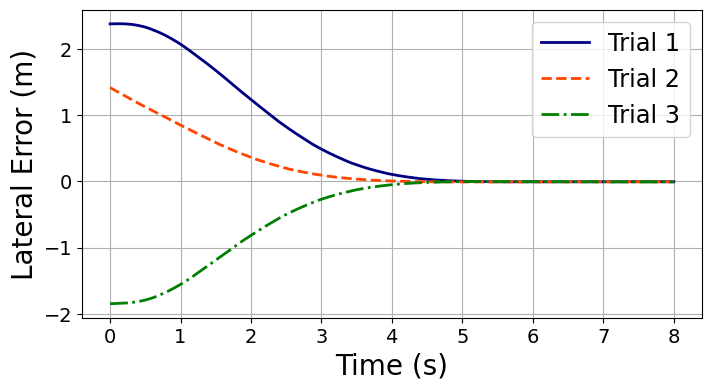

In [33]:
# Create a plot of the lateral errors
fig, axs = plt.subplots(1, 1, figsize=(8, 4), sharex=True)

# Plot lateral error
axs.plot(data['t'], data['lateral_error'], 'navy', linewidth=2, label="Trial 1")
axs.plot(data2['t'], data2['lateral_error'], linestyle='dashed', color='orangered', linewidth=2, label="Trial 2")
axs.plot(data3['t'], data3['lateral_error'], linestyle='dashdot', color='green', linewidth=2, label="Trial 3")
axs.grid()
axs.tick_params(labelsize=14)
axs.set_ylabel('Lateral Error (m)', fontsize=20)
axs.set_xlabel('Time (s)', fontsize=20)
axs.legend(fontsize='xx-large')

Find the lateral error value of each trial at 4 seconds to verify our requirement.

In [34]:
ind = np.argmin(abs(data['t']-4.0))

error_trial_1 = data['lateral_error'][ind]
error_trial_2 = data2['lateral_error'][ind]
error_trial_3 = data3['lateral_error'][ind]

print('Lateral Error at 4 seconds for Trial 1 (in m): ', error_trial_1)
print('Lateral Error at 4 seconds for Trial 2 (in m): ', error_trial_2)
print('Lateral Error at 4 seconds for Trial 3 (in m): ', error_trial_3)

Lateral Error at 4 seconds for Trial 1 (in m):  0.10475134778154005
Lateral Error at 4 seconds for Trial 2 (in m):  0.005368435016228107
Lateral Error at 4 seconds for Trial 3 (in m):  -0.049568087239187014
